#Про задание

В данном занятии было установленно, что в некоторых случаях, модели созданы на ООП способны работать намного быстрее, чем модели из Functional API или Sequential API. Мы также знаем, что весь смысл асинхронного алгоритма актёра-критика заключается в ускорении обучения.

Учитывая всё это, в данном задании необходимо переписать лекционный ноутбук `Асинхронный преймущественный актёр критик.ipynb` чтобы там использовалась та же модель, как в лекционном ноутбуке `Преймущественный актёр критик с тензорфлоу.ipynb`. Итогом этого задания должно быть значительное ускорение в обучении усинхронного алгоритма.  


#Практика

Как обычно, сначала нам нужно скачать ROM-файлы, для корректной работы среды gym.

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-02-23 18:55:46--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   491KB/s    in 23s     

2022-02-23 18:56:09 (471 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

Затем нужно смонтировать гугл-диск и импортировать все нужные библиотеки и модули.

Из новых модулей добавляются: **asyncio**, **multiprocessing**, и **threading**. Все эти модули позваляют нам взамодействовать с центральном процессором машины, чтобы прогонять код на разных потоках одновременно. Таким образом, код выполняется параллельно.

In [ ]:
# #Монтируем гугл-диск
from google.colab import drive
drive.mount('/content/drive')

import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop, Adam #Импортируем оптимизатор RMSprop и Adam
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

import multiprocessing             #Импортируем библиотеку для асинхронного программирования (используется чтобы извлечь количество cpu-ядер)
import threading                   #Импортируем библиотеку для поточного программирования (используется в создании класса)

import time                        #Импортируем модуль чтобы засекать время

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Задаем воспомогательные функции

Мы уже хорошо знакомы с всеми этими функциями из предыдущих занятий. Начнем с функции предобработки наград.

In [ ]:
#Функция для предобработки наград - принимает на вход список всех наград и значение гаммы
def preprocess_rewards(rewards_list, gamma):
  discounted_rewards = np.zeros_like(rewards_list)      #Инициализируем массив обработанных наград нулями
  running_add = 0                                       #running_add содержит предобработанную награду, которая назначается за действие - инициализируется нулем.
  for i in reversed(range(len(discounted_rewards))):    #Итерируем через массив наград в обратном порядке.
    if rewards_list[i] != 0:                            #Если на заданный момент есть не-нулевая награда, которая была назначена средой: 
      running_add = 0                                   #переменная running_add обнуляется.
    running_add = gamma * running_add + rewards_list[i] #Задаем награду за текущее действие (псевдо-уравнение Беллмена).
    discounted_rewards[i] = running_add                 #Записываем награду в массив обработанных наград
  return (discounted_rewards - np.mean(discounted_rewards))/np.std(discounted_rewards)                 #Возвращаем массив обработанных наград

Затем создадим функцию которая обрабатывает кадр (эта функция используется внутри другой функции, которая соеденяет два кадра - также задаем возможные действия агента).

In [ ]:
#Функция для предобработки состояния - удаляет фон, уберает края картинки, и затем сжимает картинку вдвое
def preprocess_frame(frame):       #Функция принимает кадр на вход
  frame = frame.astype(np.float32) #Меняем тип данных на float32

  frame = frame[35:195]            #Отсекаем ненужные части кадра, которые не пренадлежат игровому полю.
  frame = frame[::2, ::2, 0]       #Сжимаем изображение (берём каждый второй пиксель)

  frame[frame == 144] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame == 109] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame != 0] = 1            #Всё, что не пренадлежит фону, меняем на белый цвет (значение пикселя = 1)
  return frame.reshape(80, 80, 1)  #Меняем форму итогового кадра на (80, 80, 1)

#Создадим функцию для "склеивание" двух кадров - этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.
def stack_frames(new_frame, old_frame):                    #Функция принимает два изображения на вход: новое и старое                   
  new_frame = preprocess_frame(new_frame)                  #Предобрабатываем новое изображение (используем выше объявленную функцию)
  old_frame = preprocess_frame(old_frame)                  #Предобрабатываем старое изображение (используем выше объявленную функцию)
  return np.concatenate([new_frame, old_frame], axis = -1) #Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

action_space = [2, 3] #2 означает двигаться вверх, 3 означает двинатьзя вниз

Также зададим функцию для отображения результатов, и её воспомогательную функцию которая считает скользящее среднее.

In [ ]:
def moving_average(data, width = 100): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

#Функция для отображения результатов, выводит графики очков и длительности эпизодов
def show_results(all_results_list, all_durations_list):
  output.clear()                                                                                 #Удаляем предыдущие выводы
  fig, ax = plt.subplots(1, 2, figsize = (20, 8))                                                #Создаем два графика внутри одного полотна
  ax[0].plot(Worker.all_rewards_list, label = 'Награда')                                         #Отрисовываем награды за каждый эпизод
  ax[0].plot(moving_average(Worker.all_rewards_list), label = 'Награда (скользящее среднее)')    #Отрисовываем скользящее среднее от всех наград
  ax[0].set_xlabel("Номер эпизода")                                                              #Добавляем лейбл для оси х
  ax[0].set_ylabel("Награда за эпизод")                                                          #Добавляем лейбл для оси у

  ax[1].plot(Worker.all_durations_list, 'r--', label = 'Количество действий')                                    #Отрисовываем длительность каждого эпизода
  ax[1].plot(moving_average(Worker.all_durations_list), 'g', label = 'Количество действий (скользящее среднее)') #Отрисовываем скользящее среднее длительности каждого эпизода
  ax[1].set_xlabel("Номер эпизода")                                                                              #Добавляем лейбл для оси х
  ax[1].set_ylabel("Длительность эпизода")                                                                       #Добавляем лейбл для оси у
  plt.show()   #Выводим результат

In [ ]:
#Создаем класс, через который будем создавать модель артёка и модель критика
#Инициализатор класса принимает на вход лишь один параметр - количество возможных действий в среде.
#Если этот параметр не задается, его значение по умолчанию будет None, что обозначает этот класс будет создавать не модель актёра, а модель критика.

class Actor_Critic(tf.keras.Model):       #Класс наследует все методы из класса tf.keras.Model - это обязательно!!!
  def __init__(self, action_size, is_actor = True):
    super().__init__()  #В первой строке при инициазизации класса нужно указать эту команду, чтобы инициализировать наследственный класс. Иначе класс не будет работать!
    self.flatten = Flatten()    #Задаем выравнивающий слой в самом начале
    self.dense_1 = Dense(1024, activation = 'elu') #Задаем первый полносвязанный слой с 1024 нейронов
    self.dense_2 = Dense(512, activation = 'elu')   #Задаем второй полносвязанный слой с 512 нейронов
    if is_actor:   #Если параметр is_actor имеет соответствующее значение, мы создаем актёра.
      self.output_layer = Dense(action_size, activation = 'softmax') #Соответственно, создаем полносвязанный выходной слой с action_size количество нейронов (action_size это количество уникальных действий в среде).
    else:             #Иначе:
      self.output_layer = Dense(1) #Создаем выходной слой с 1 нейроном и линейной активационной функцией (т.е. создаем критика)
        
  #Также, нам необходимо создать метод для вызова класса. Этот метод содержит прямой проход нейронной сети,
  #то есть именно в этом методе мы определяем как слои связанны между друг-другом и как они обрабатывают данные.
  #Функция вызова принимает на вход два параметра, потому что у нейронной сети действительно будет два входа - оба которые будут принимать данные из игровой среды   
  def __call__(self, input_data, training = False):
    x = self.flatten(input_data) #Применяем выравнивающий слой с входными данными
    x = self.dense_1(x)    #Подаем результат выравнения к первому полносвязанному слою.
    x = self.dense_2(x)    #Подаем результат первого полносвязанного слоя к второму полносвязанному слою
    output_data = self.output_layer(x) #Выход второго полносвязанного слоя подаем на последний слой нейронной сети (action_size нейронов если это актёр, иначе 1 нейрон)
    return output_data   #Возвращаем результат обработки нейронной сети

#Добавляем обёртку tf.function (это помогает сильно ускорить работу функции, но работает только с функциями tensorflow)
#Из-за того, что мы не можем использовать numpy в функции с tf.function, часть кода с выбором действий выведена из функции. 
#Внутри функции остался только код для предсказания вероятностей.
@tf.function
def choose_action(state, model):     
  state = tf.expand_dims(state, axis = 0)
  #Из предикта модели принимаем вероятности 
  actor_probs = model(state)    
  return actor_probs  #Возвращаем действие

Теперь можно создавать нашего агента. 

In [ ]:
#Создаем объект главного узла
class Master_Agent:
  def __init__(self, load_pretrained = False):
    self.env_name = 'Pong-v4'             #Задаем имя среды gym
    self.env = gym.make(self.env_name)    #Инициализируем среду
    self.action_size = len(action_space)  #Записываем количество действий в среде
    self.global_actor_model = Actor_Critic(self.action_size, is_actor = True)    #Создаем глобальную модель актёра главного узла
    self.global_critic_model = Actor_Critic(self.action_size, is_actor = False) #Создаем глобальную модель критика внутри главного узла
    self.FOLDER_PATH = '/content/drive/My Drive/pretrained_networks/a3c/' #Задаем путь куда будем сохранять веса модели
    self.load_pretrained = load_pretrained           #Записываем если загружаем новые данные или начинаем обучение с нуля

  #Задаем метод обучения
  @tf.function
  def train(self): #Сначала создаем рабочие узлы, которые будут взаимодействовать с средой и обучать одну, глобальную модель (по факту у нас несколько агентов)
    #Мы создадим столько же агентов, сколько ядер в процессоре (в колабе обычно 2 ядра в процессоре)
    workers = [Worker(self, self.env_name, self.action_size, self.global_actor_model, self.global_critic_model, self.load_pretrained, i) for i in range(multiprocessing.cpu_count())]
    for i, worker in enumerate(workers): #Затем, в цикле запускаем каждый рабочий узел
      print("Запускается {}-й рабочий узел".format(i))
      worker.start()
    [w.join() for w in workers] #Обьединяем все узлы в одну программу

In [ ]:
#Создаем функцию для подсчета ошибки предсказания актёра.
#Функция принимает на вход две части состояния по которым совершается предсказания, действия совершенны в игровой среде, и преймущества которые подсчитываются с помощью критика
#Не забываем добавить обертку tf.function чтобы ускорить работу кода
@tf.function
def calculate_actor_loss(model, environment_states, actions, advantages):
  actor_probabilities = model(environment_states) #Подаем две отдельные части состояния на вход нейронной сети, чтобы получить вероятности действий

  cce = tf.keras.losses.CategoricalCrossentropy() #В качестве ошибки используем категориальную кросс-энтропию
  actor_loss = cce(actions, actor_probabilities, sample_weight = advantages) #Считаем кросс-энтропию, используем преймущества в качестве весов сэмплирования
    
  #Добавляем небольшую ошибку энтропии - таким образом, агент получает наказание за слишком большую уверенность в действии 
  #это позволяет алгоритму лучше исследовать среду и не переобучаться - без этого элемента возможно что ничего в принцине не получиться
  entropy_loss = 0.01 * tf.reduce_mean(actions * tf.math.log(actor_probabilities)) 
  return actor_loss + entropy_loss #Возвращаем сумму двух ошибок

#Создаем функцию для подсчета ошибки критика.
#Функция принимает на вход две части состояния по которым совершается предсказания, и награды из игровой среды
#Не забываем добавить обертку tf.function чтобы ускорить работу кода
@tf.function
def calculate_critic_loss(model, environment_states, rewards):
  values = model(environment_states)                  #Подаем две отдельные части состояния на вход нейронной сети, чтобы получить предсказанную награду
  critic_loss = tf.keras.losses.MSE(rewards, values)  #Считаем MSE с всех значений - сначала просто считаем квадратную ошибку для каждого примера отдельно, затем берём среднее
  return critic_loss, values #Возвращаем скалярное значение ошибки

actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)   #Создаем оптимизатор RMSprop для актёра   
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 5e-4)  #Создаем оптимизатор RMSprop для критика   

Дальше создаем класс рабочего узла, который будет взаимодействовать с средой и собирать данные для обучения. Нужно отметить что рабочий узел собирает данные используя *локальную* модель (т.е. модель которая находится внутри рабочего узла), но обучает *глобальную* модель (т.е. модель которая находится внутри главного узла).

In [ ]:
#Создаем класс рабочего узла
class Worker(threading.Thread):
  global_episode = 0           #Общий параметр для всех объектов класса - номер текущего эпизода, инициализируется как 0
  save_lock = threading.Lock() #Общий параметр для всех объектов класса - блокировка узлов (чтобы два рабочих узла не сохраняли данные одновременно и не конфликтовали)
  all_rewards_list = []        #Общий параметр для всех объектов класса - список всех полученых наград
  all_durations_list = []      #Общий параметр для всех объектов класса - список длительностей всех эпизодов

  #Создаем функцию для инициализации класса, которая будет принимать на вход родительский объект, имя среды, количество возможных действий,
  #глобальную модель актёра, глобальную модель критика, параметр о загрузке ранее обученных сетей, и индекс рабочего узла.
  def __init__(self, parent, env_name, action_size, global_actor_model, global_critic_model, load_pretrained, index):
    super(Worker, self).__init__() #Инициализируем родительский класс рабочего узла
    self.parent = parent           #Устанавливаем родительский объект узла
    self.action_size = action_size #Устанавливаем количество возможных действий
    self.global_actor_model = global_actor_model  #Записываем глобальную модель актёра
    self.local_actor_model = global_actor_model   #Создаем локальную модель актёра используя глобальную модель актёра
    self.global_critic_model = global_critic_model#Записываем глобальную модель критика
    self.local_critic_model = global_critic_model #Создаем локальную модель критика используя глобальную модель критика
    self.worker_index = index             #Записываем индекс рабочего узла
    self.env = gym.make(env_name)         #Создаем игровую среду
    if load_pretrained:                   #Если хотим продолжить обучение с ранее сохранненой точки:
      self.global_actor_model.load_weights(os.path.join(self.parent.FOLDER_PATH, 'actor.h5'))  #Загружаем веса глобальной модели актёра из указанного файла
      self.global_critic_model.load_weights(os.path.join(self.parent.FOLDER_PATH, 'critic.h5'))#Загружаем веса глобальной модели критика из указанного файла
      with open(os.path.join(self.parent.FOLDER_PATH, '/test.txt'), 'rb') as f: #Открываем файл, где сохраняли прочие данные:
        Worker.all_rewards_list, Worker.all_durations_list = pickle.load(f)     #Загружаем список всех наград и длительностей эпизодов из файла

  #Создаем функцию, внутри которой будем играть в эпизод, обучать алгоритм, и выводить графики
  def run(self):
    while True: #Создаем бесконечный цикл, внутри которого выполняются все функции рабочего узла
      Worker.global_episode += 1 #Увеличиваем количество эпизодов на 1
      episode_states = []      #Инициализируем пустой список где будем хранить все состояния из эпизода
      episode_actions = []     #Инициализируем пустой список где будем хранить все действия из эпизода
      episode_rewards = []     #Инициализируем пустой список где будем хранить все награды из эпизода
      new_frame = self.env.reset() #Стартуем новый ипизод и извлекаем первый кадр из эпизода
      old_frame = new_frame        #Старый кадр инициализируется как текущий кадр
      episode_reward = 0           #Награда за эпизод инициализируется нулем
      done = False                 #Инициализируем параметр, который указывает что эпизод не завершён
      state = stack_frames(new_frame, old_frame) #Задаем состояние среды (вход нейросети) используя старый и новый кадр
      while not done:                            #В цикле выполняем блок кода до завершения эпизода
        actor_probs = choose_action(tf.convert_to_tensor(state), self.local_actor_model) #Выбираем действие используя состояние и нейронную сеть
        action_index = np.random.choice(self.parent.action_size, p = np.array(actor_probs).flatten()) #Выбираем рандомное действие по предсказанным вероятностям
        new_frame, reward, done, misc = self.env.step(action_space[action_index]) #Подаем действие в локальную среду, получаем состояние сруды, награду, статус завершение игры, и прочую информацию
        episode_states.append(state)               #Добавляем состояние среды в соответствующий список
        episode_actions.append(action_index)       #Добавляем индекс действия в соответствующий список
        episode_rewards.append(reward)             #Добавляем награду в соответствующий список
        state = stack_frames(new_frame, old_frame) #Создаем новое состояние используя новый кадр
        old_frame = new_frame                      #Записываем старый кадр как новый кадр
      
      #Начало нового эпизода
      self.train_model(np.array(episode_states), np.array(episode_actions), np.array(episode_rewards)) #После завершения эпизода обучаем глобальные модели на состояниях, действиях, и наград
      self.local_actor_model.set_weights(self.global_actor_model.get_weights())   #Устанавливаем веса локальной модели актёра через только-что обученые веса глобальной модели актёра
      self.local_critic_model.set_weights(self.global_critic_model.get_weights()) #Устанавливаем веса локальной модели критика через только-что обученые веса глобальной модели критика
      Worker.all_rewards_list.append(sum(episode_rewards))    #Добавляем количество очков (сумма наград) в соответствующий список
      Worker.all_durations_list.append(len(episode_rewards))  #Добавляем длительность эпизода (количество наград) в соответствующий список
      show_results(Worker.all_rewards_list, Worker.all_durations_list) #Отображаем график с очками за эпизод и длительностью эпизодов
      if Worker.global_episode % 10 == 0:                              #В каждый 10-й эпизод:
        self.global_actor_model.save_weights(os.path.join(self.parent.FOLDER_PATH, 'actor.h5'))   #Сохраняем глобальные веса актёра в файл
        self.global_critic_model.save_weights(os.path.join(self.parent.FOLDER_PATH, 'critic.h5')) #Сохраняем глобальные веса критика в файл
        with open(os.path.join(self.parent.FOLDER_PATH, '/critic.txt'), 'wb') as f:         #Открываем файл куда будем сохранять данные
         pickle.dump([Worker.all_rewards_list, Worker.all_durations_list], f)               #Сохраняем список всех наград и длительностей эпизодов в файл

  #Также создадим отдельную функцию, где будет происходить обучение глобальных моделей актёра и критика
  def train_model(self, episode_states, episode_actions, episode_rewards):
    rewards = preprocess_rewards(episode_rewards, 0.98)       #Предобрабатываем награды (также как это делалось в занятии по градиентной политике)
    episode_states = tf.convert_to_tensor(episode_states, dtype = tf.float32)
    episode_actions = tf.convert_to_tensor(tf.keras.utils.to_categorical(episode_actions, len(action_space)), dtype = tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype = tf.float32)

    with tf.GradientTape() as tape:
      critic_loss, values = calculate_critic_loss(self.local_critic_model, episode_states, rewards)
    critic_gradients = tape.gradient(critic_loss, self.local_critic_model.trainable_variables)           #Используем значение ошибки чтобы подсчитать градиенты
    critic_optimizer.apply_gradients(zip(critic_gradients, self.local_critic_model.trainable_variables)) #Проводим обучение - применяем градиенты к обучаемым параметрам модели критика

    episode_advantages = rewards - values.numpy().flatten()      #Применяем уравнение для вычисления преймуществ - по определению A(s, a) = Q(s, a) - V(s)

    with tf.GradientTape() as tape:
      actor_loss = calculate_actor_loss(self.local_actor_model, episode_states, episode_actions, episode_advantages)
    actor_gradients = tape.gradient(actor_loss, self.local_actor_model.trainable_variables)           #Используем значение ошибки чтобы подсчитать градиенты
    actor_optimizer.apply_gradients(zip(actor_gradients, self.local_actor_model.trainable_variables)) #Проводим обучение - применяем градиенты к обучаемым параметрам модели критика

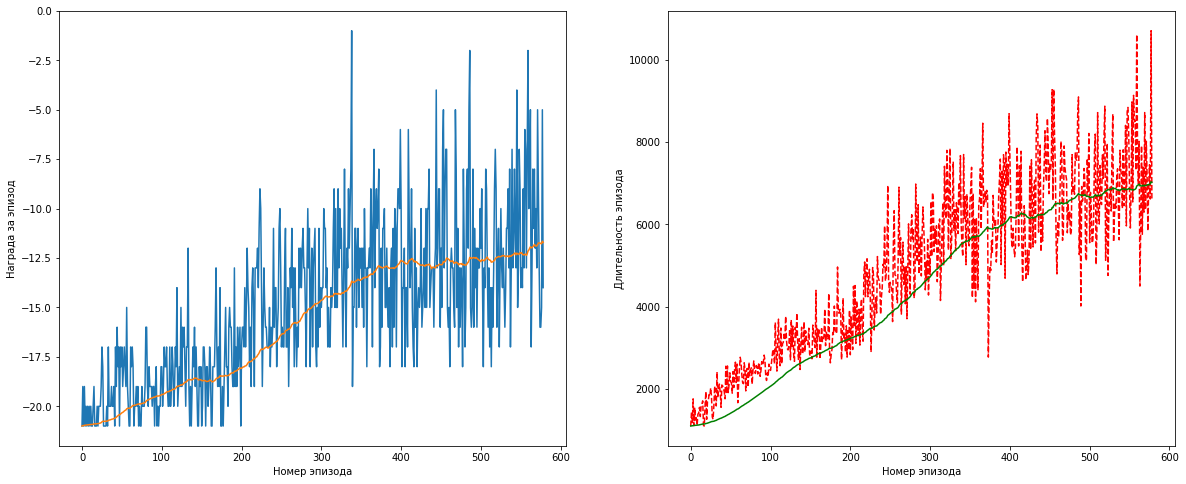

In [ ]:
agent = Master_Agent(load_pretrained = False) #Создаем объект мастер-узла, в котором содержиться агент
agent.train()                                 #Обучаем агента

В данной реализации, код выполняется намного (примерно в 10 раз) быстрее - но при этом код значительно сложнее.